# Modeling with linear regression #

will start with a single variable and keep adding more to see if R squared improves and assumptions of regression are met along the way....

importing all relevant libraries

In [72]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
sns.set_style('darkgrid')

reading in csv file containing all the relevent features we are interested in to explore and find a model

many of the predictors chosen are categorical, my initial attempt will be to use continuous variables alone and then work with categorical variables....

In [3]:
df = pd.read_csv('our_dataframe.csv', index_col=0)

In [4]:
df.columns

Index(['saleprice', 'sqfttotliving', 'yrbuilt', 'yrrenovated', 'bedrooms',
       'zipcode', 'sqfttotbasement', 'sqftfinbasement', 'sqftopenporch',
       'sqftenclosedporch', 'sqftdeck', 'heatsystem', 'heatsource',
       'bathhalfcount', 'bath3qtrcount', 'bathfullcount', 'condition',
       'viewutilization', 'sqftgarageattached', 'daylightbasement',
       'finbasementgrade', 'hbuasifvacant', 'inadequateparking', 'mtrainier',
       'olympics', 'cascades', 'territorial', 'seattleskyline', 'pugetsound',
       'lakewashington', 'lakesammamish', 'smalllakerivercreek', 'otherview',
       'wfntlocation', 'trafficnoise', 'airportnoise', 'powerlines',
       'othernuisances', 'adjacentgreenbelt'],
      dtype='object')

Adding in bath, porch, price per square foot in data frame and dropping individual columns containing parts of these newly added columns

In [5]:
df['porch'] = df['sqftopenporch'] + df['sqftenclosedporch']
df['baths'] = df['bathfullcount'] + (0.75*df['bath3qtrcount']) + (0.5*df['bathhalfcount'])
df.drop(columns=['sqftopenporch', 'sqftenclosedporch', 'bathfullcount', 'bath3qtrcount',
                 'bathhalfcount'], inplace=True)

In [6]:
df['pricepersqft'] = df['saleprice']/df['sqfttotliving']
df['pricepersqft_finbasement'] = df['saleprice']/ (df['sqfttotliving'] + df['sqftfinbasement'])

In [7]:
df.shape

(18293, 38)

18293 entries at present, removing outliers in saleprice that are 3 sigma away from the mean

In [8]:
mean, std = df['saleprice'].agg(['mean', 'std'])
print("mean = {} and std = {}".format(mean, std))
def z_score(row):
    return (row - mean) / std

df['z_score'] = df.saleprice.apply(z_score)
df = df[abs(df['z_score']) < 3]
df

mean = 794780.5823539059 and std = 586231.7130403558


,saleprice,sqfttotliving,yrbuilt,yrrenovated,bedrooms,zipcode,sqfttotbasement,sqftfinbasement,sqftdeck,heatsystem,...,trafficnoise,airportnoise,powerlines,othernuisances,adjacentgreenbelt,porch,baths,pricepersqft,pricepersqft_finbasement,z_score
0,1910000,3990,1952,2019,6,98125,1360,1360,1070,7,...,0,0,N,N,N,110,4.50,478.696742,357.009346,1.902353
1,1089950,3920,2018,0,5,98028.0,930,930,0,5,...,0,0,N,N,N,550,3.25,278.048469,224.731959,0.503503
2,412500,2280,1958,0,4,98056,1140,1140,0,7,...,1,0,N,N,N,0,1.75,180.921053,120.614035,-0.652098
3,541000,1030,1965,0,3,98052,0,0,0,5,...,0,0,N,N,N,210,1.50,525.242718,525.242718,-0.432901
4,1020000,2410,1939,0,3,98144,1070,1070,170,5,...,1,0,N,N,N,0,1.75,423.236515,293.103448,0.384182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18288,1201000,3680,1974,0,5,98072,0,0,1000,5,...,0,0,N,N,N,50,3.00,326.358696,326.358696,0.692933
18289,921000,2280,2016,0,3,NaN,0,0,0,5,...,0,0,N,N,N,110,2.50,403.947368,403.947368,0.215306
18290,627000,3820,1967,0,5,98058,0,0,0,5,...,0,0,N,N,N,80,2.25,164.136126,164.136126,-0.286202
18291,640000,2450,2015,0,4,98146,0,0,0,5,...,2,0,N,N,N,50,2.50,261.224490,261.224490,-0.264026


In [9]:
outliers_removed = 18293 - 17990
print('the outliers that were 3 sigma away from the mean related to ', outliers_removed, ' entries')

the outliers that were 3 sigma away from the mean related to  303  entries


In [10]:
df['saleprice'].describe()

count    1.799000e+04
mean     7.452165e+05
std      3.909353e+05
min      1.000000e+01
25%      4.690000e+05
50%      6.500000e+05
75%      8.899970e+05
max      2.550000e+06
Name: saleprice, dtype: float64

In [12]:
mean, std = df['saleprice'].agg(['mean', 'std'])
print("mean = {} and std = {}".format(mean, std))

mean = 745216.4739855475 and std = 390935.27068573574


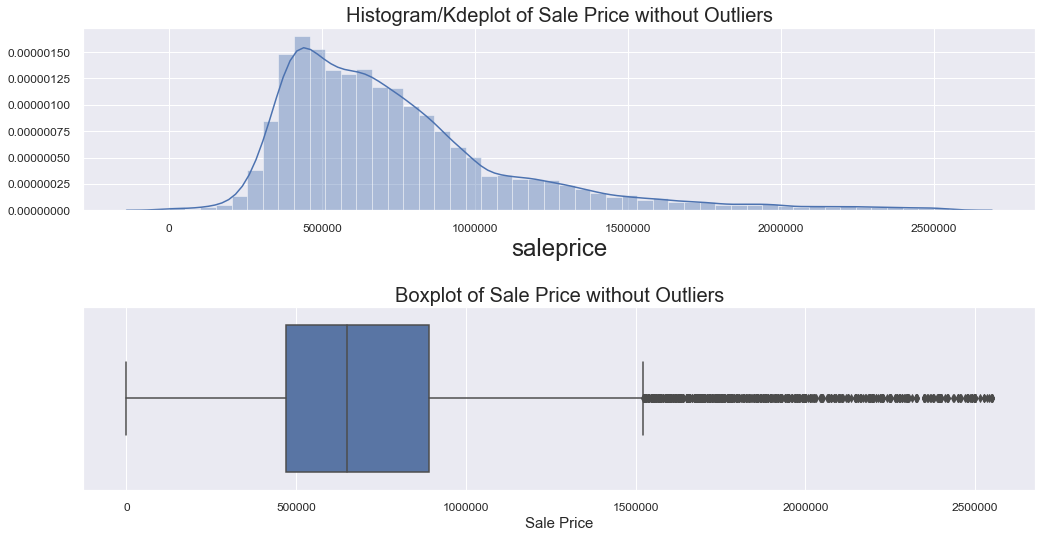

In [61]:
fig, ax = plt.subplots(2,1, figsize=(15, 8))
sns.distplot(df.saleprice, ax = ax[0])
sns.boxplot(df.saleprice, ax= ax[1])
ax[0].set_title('Histogram/Kdeplot of Sale Price without Outliers', fontsize=20)
ax[1].set_title('Boxplot of Sale Price without Outliers', fontsize=20)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].tick_params(axis='both', labelsize=12)
plt.xlabel('Sale Price', fontsize = 15)
plt.tight_layout();

Since the target now seems reasonable lets chug along and try and build some models based on correlation 
(keep an eye out for categorical variables, need to treat them differently)

In [20]:
df.columns

Index(['saleprice', 'sqfttotliving', 'yrbuilt', 'yrrenovated', 'bedrooms',
       'zipcode', 'sqfttotbasement', 'sqftfinbasement', 'sqftdeck',
       'heatsystem', 'heatsource', 'condition', 'viewutilization',
       'sqftgarageattached', 'daylightbasement', 'finbasementgrade',
       'hbuasifvacant', 'inadequateparking', 'mtrainier', 'olympics',
       'cascades', 'territorial', 'seattleskyline', 'pugetsound',
       'lakewashington', 'lakesammamish', 'smalllakerivercreek', 'otherview',
       'wfntlocation', 'trafficnoise', 'airportnoise', 'powerlines',
       'othernuisances', 'adjacentgreenbelt', 'porch', 'baths', 'pricepersqft',
       'pricepersqft_finbasement', 'z_score'],
      dtype='object')

In [22]:
df_corr = df.corr()['saleprice'].sort_values(ascending=False)

In [23]:
df_corr[abs(df_corr) > 0.2]

saleprice                   1.000000
z_score                     1.000000
sqfttotliving               0.636020
baths                       0.505118
pricepersqft                0.456108
pricepersqft_finbasement    0.379512
bedrooms                    0.316679
sqftfinbasement             0.255762
territorial                 0.254336
sqfttotbasement             0.243885
porch                       0.235681
finbasementgrade            0.217988
sqftdeck                    0.216612
lakewashington              0.200085
Name: saleprice, dtype: float64

choosing the highest correlation with saleprice and also choosing only the features of the property for now (will look into the location aspects which is the key in real estate as we progress)

sqfttotliving 0.636020 vs pricepersqft 0.456108 vs pricepersqft_finbasement 0.379512 (essentially the same thing in different forms, can include the one that best suits the R-squareed and works with other predictors)

baths 0.505118

sqftfinbasement 0.255762, sqfttotbasement 0.243885

bedrooms  0.316679

porch 0.235681

deck 0.216612

checking for linearity between the chosen predictors

In [28]:
high_corr = ['saleprice', 'sqfttotliving', 'baths', 'pricepersqft', 'pricepersqft_finbasement',
              'bedrooms', 'sqftfinbasement','sqfttotbasement', 'porch', 'sqftdeck']

In [29]:
high_corr_df = df[high_corr]

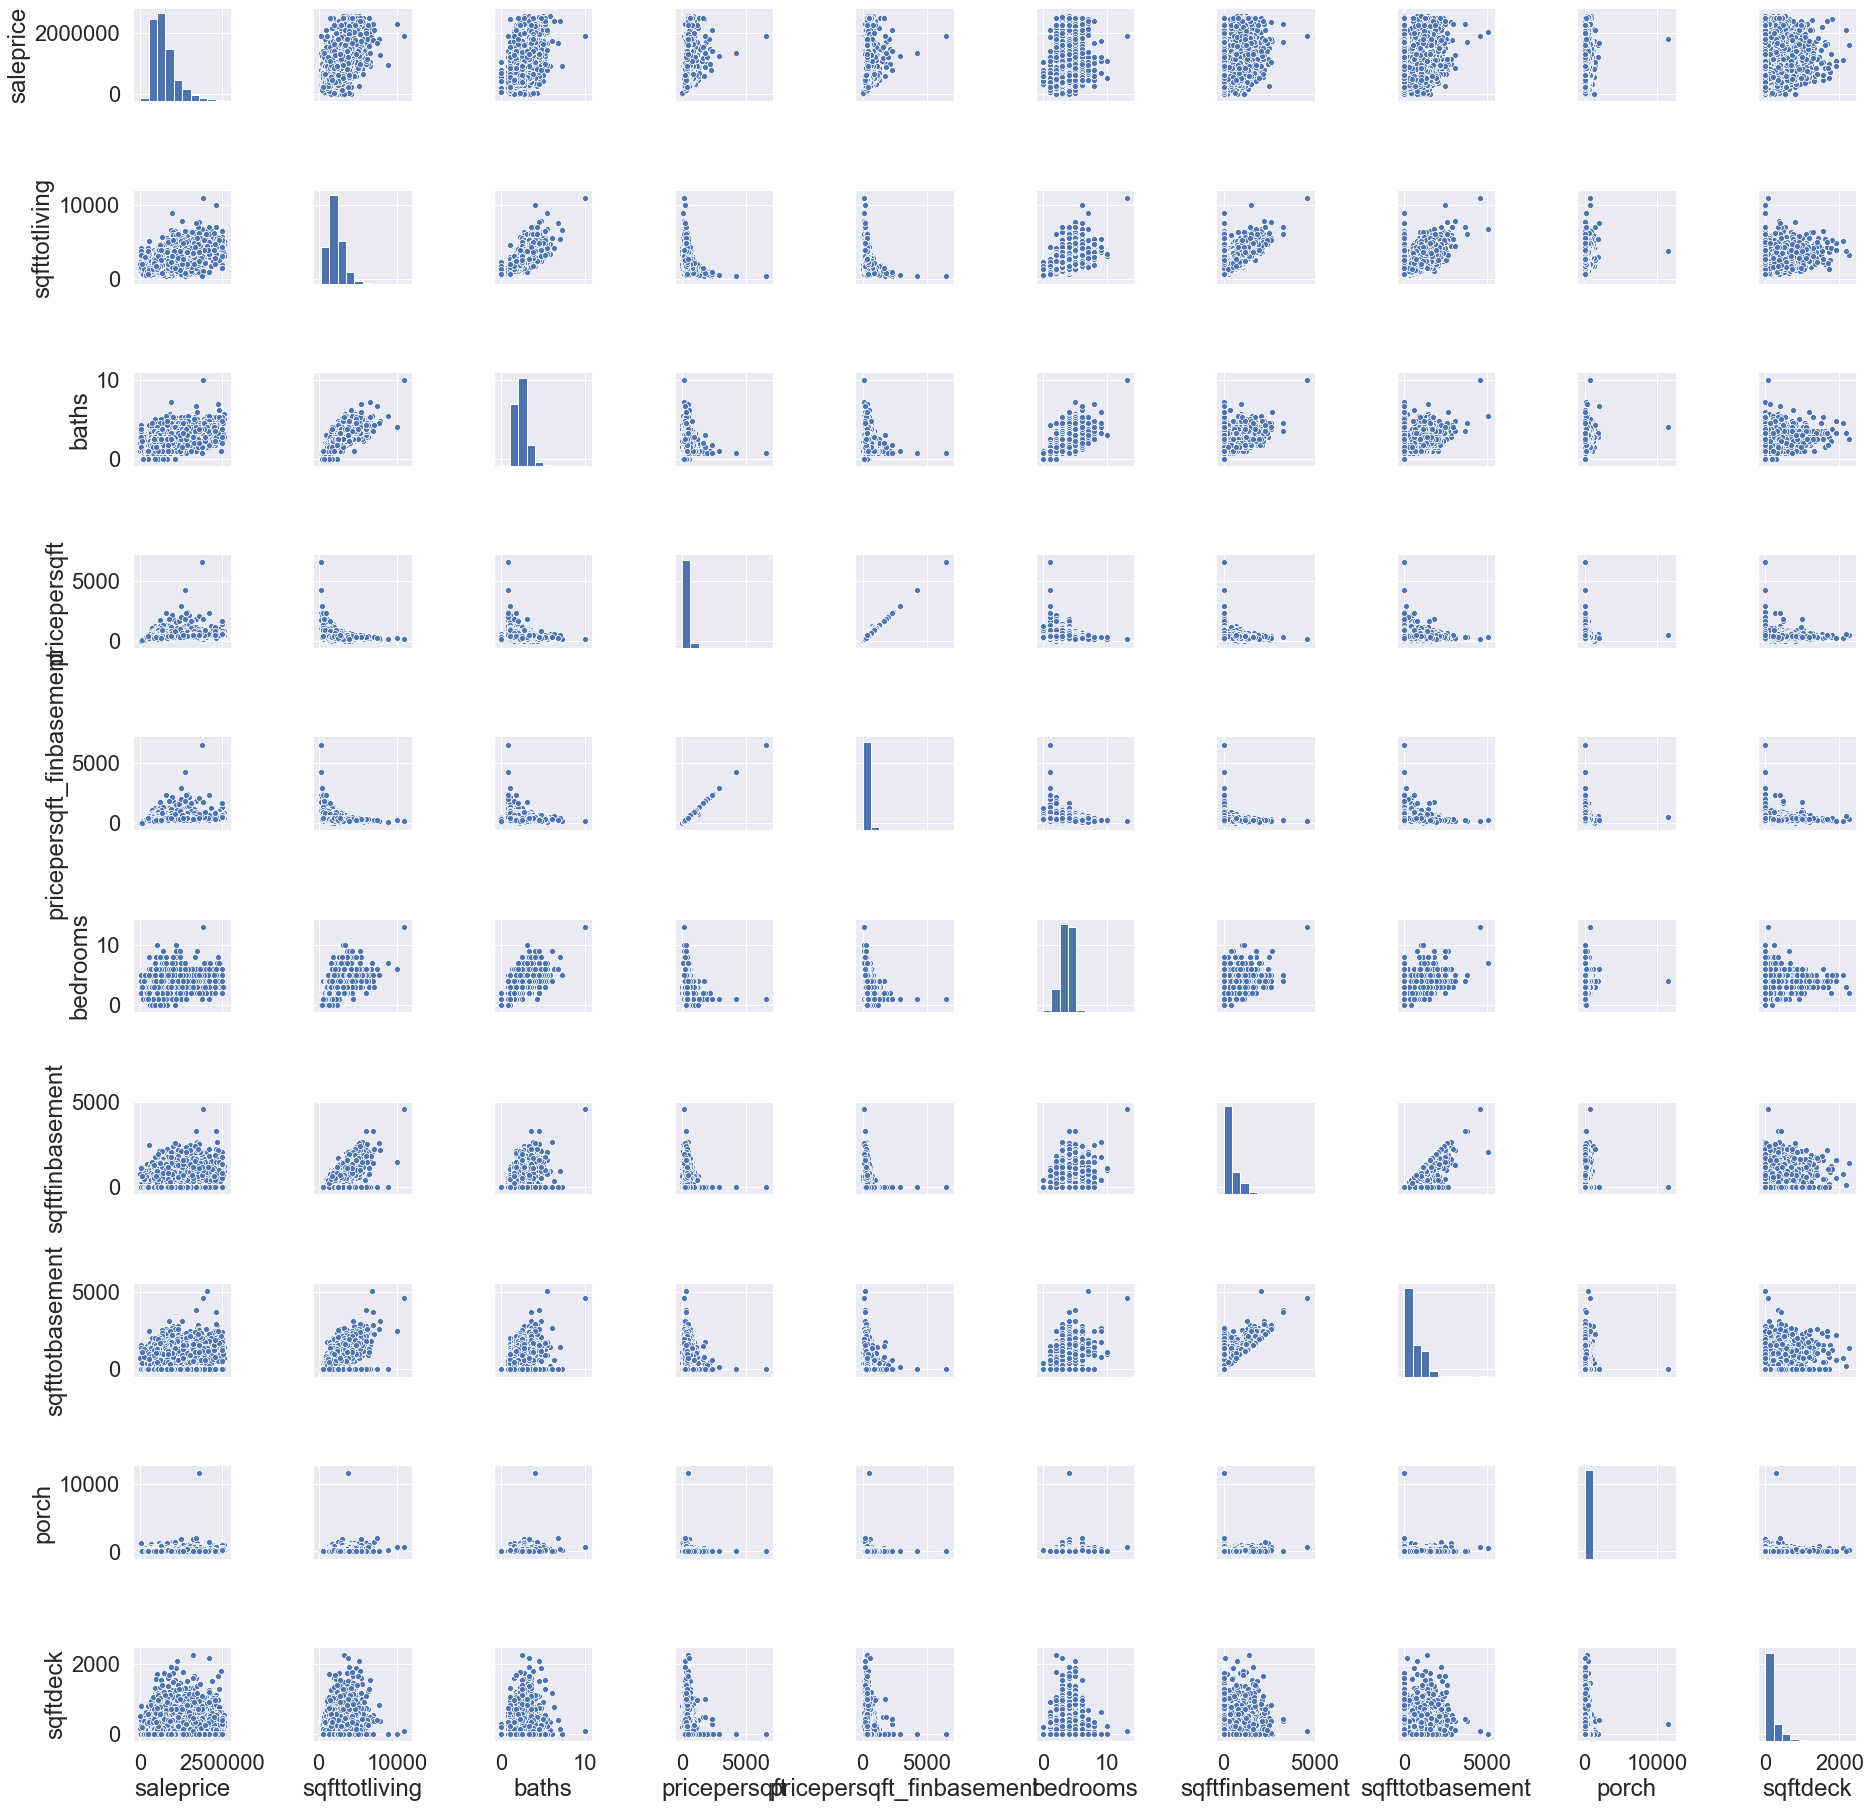

In [62]:
sns.pairplot(high_corr_df)
sns.set(font_scale = 2);

In [32]:
high_corr_df.corr()

,saleprice,sqfttotliving,baths,pricepersqft,pricepersqft_finbasement,bedrooms,sqftfinbasement,sqfttotbasement,porch,sqftdeck
saleprice,1.000000,0.636020,0.505118,0.456108,0.379512,0.316679,0.255762,0.243885,0.235681,0.216612
sqfttotliving,0.636020,1.000000,0.759014,-0.266439,-0.298904,0.625069,0.386867,0.272973,0.312982,0.227035
baths,0.505118,0.759014,1.000000,-0.210115,-0.244382,0.568648,0.265876,0.170609,0.234980,0.170655
pricepersqft,0.456108,-0.266439,-0.210115,1.000000,0.960074,-0.305365,-0.091323,0.018153,-0.038813,0.013669
pricepersqft_finbasement,0.379512,-0.298904,-0.244382,0.960074,1.000000,-0.331917,-0.313774,-0.182286,-0.014667,-0.046655
bedrooms,0.316679,0.625069,0.568648,-0.305365,-0.331917,1.000000,0.289720,0.210262,0.148985,0.090695
sqftfinbasement,0.255762,0.386867,0.265876,-0.091323,-0.313774,0.289720,1.000000,0.848621,-0.018217,0.283568
sqfttotbasement,0.243885,0.272973,0.170609,0.018153,-0.182286,0.210262,0.848621,1.000000,-0.035838,0.259692
porch,0.235681,0.312982,0.234980,-0.038813,-0.014667,0.148985,-0.018217,-0.035838,1.000000,-0.020999
sqftdeck,0.216612,0.227035,0.170655,0.013669,-0.046655,0.090695,0.283568,0.259692,-0.020999,1.000000


Although not too obviuos from the pairplots there's some correlation (linearity) with the target with each of the predictors however, some of these variables themselves have multicollinearity and some of them are essentially a different from of another, keeping these aspects in mind lets start our modeling now....

In [37]:
# Create a dataframe with only the target and the chosen high-positive corellation feature
fsm_df = df[['saleprice', 'sqfttotliving']].copy()

# Fit the model on the dataframe composed of the two features
formula = 'saleprice ~ sqfttotliving'
fsm = ols(formula=formula, data=fsm_df).fit()
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                 1.222e+04
Date:                Tue, 16 Jun 2020   Prob (F-statistic):               0.00
Time:                        23:04:17   Log-Likelihood:            -2.5251e+05
No. Observations:               17990   AIC:                         5.050e+05
Df Residuals:                   17988   BIC:                         5.050e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.579e+05   5769.734     27.363      0.000    1.47e+05    1.69e+05
sqfttotliving   278.7965      2.522    110.542      0.000     273.853     283.740
==============================================================================
Omnibus:                     3314.686   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8492.054
Skew:                           1.014   Prob(JB):                         0.00
Kurtosis:                       5.687   Cond. No.                     5.87e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
rsquared = fsm.rsquared
params = fsm.params
print(f'Rsquared of FSM: {rsquared}')
print('----------')
print('Beta values of FSM:')
print(params)

Rsquared of FSM: 0.4045215701384719
----------
Beta values of FSM:
Intercept        157874.946900
sqfttotliving       278.796461
dtype: float64


Check for Assumptions:

**1) Linearity**

Linear regression assumes that the input variable linearly predicts the output variable. We already qualitatively checked that with a scatter plot. But it's also a good idea to use a statistical test.

In [41]:
rainbow_statistic, rainbow_p_value = linear_rainbow(fsm)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0221836194654248
Rainbow p-value: 0.14908349992009914


The null hypothesis is that the model is linearly predicted by the features, alternative hypothesis is that it is not.

**2) Normality**

Linear regression assumes that the residuals are normally distributed. It is possible to check this qualitatively with a Q-Q plot. The fit model object has an attribute called resid, which is an array of the difference between predicted and true values. Store the residuals in the variable below, show the qq plot, and interepret. You are looking for the theoretical quantiles and the sample quantiles to line up.

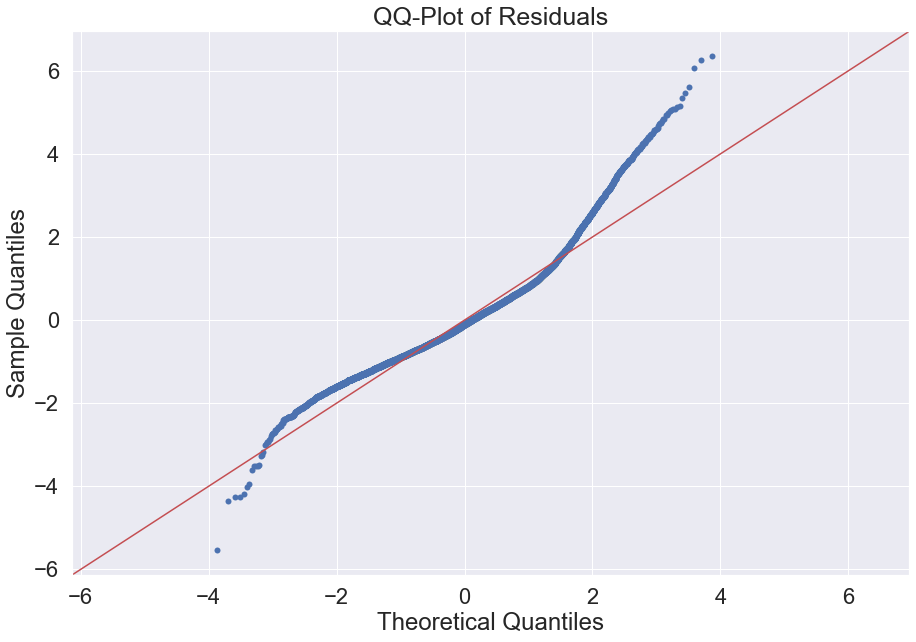

In [64]:
fig, ax = plt.subplots(figsize=(15,10))
residuals = fsm.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=ax)
ax.set_title('QQ-Plot of Residuals', fontsize = 25);

To pass a visual test, the qq should be a straight line.

**3)Homoscadasicity**

Linear regression assumes that the variance of the dependent variable is homogeneous across different values of the independent variable(s). We can visualize this by looking at the predicted life expectancy vs. the residuals.

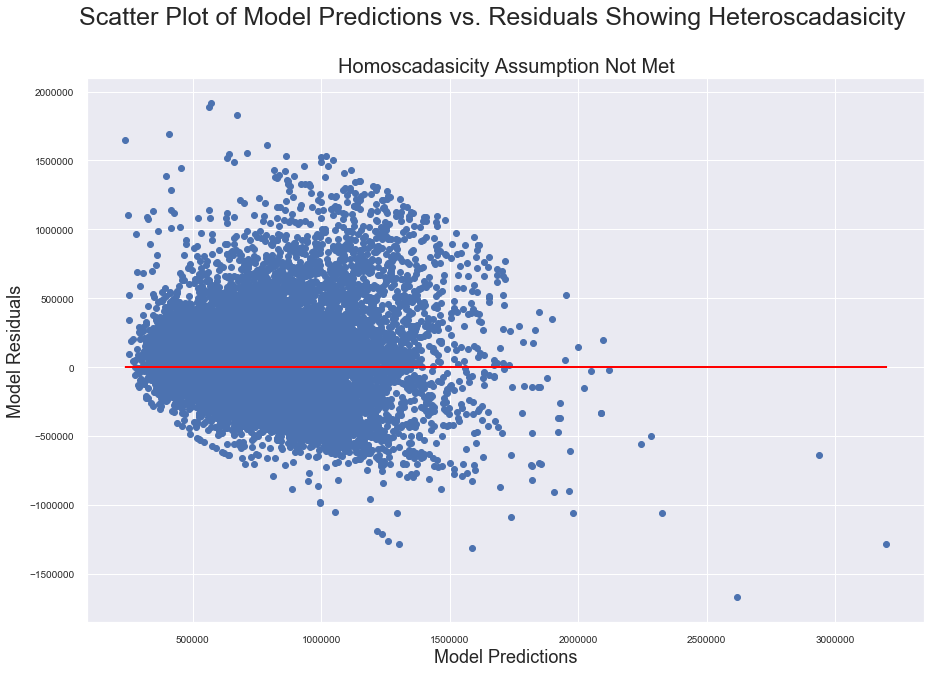

In [65]:
fig, ax = plt.subplots(figsize = (15, 10))
plt.scatter(fsm.predict(), fsm.resid)
sns.set(font_scale = 1)
fig.suptitle('Scatter Plot of Model Predictions vs. Residuals Showing Heteroscadasicity', fontsize = 25)
ax.set_title('Homoscadasicity Assumption Not Met', fontsize = 20)
plt.xlabel('Model Predictions', fontsize = 18)
plt.ylabel('Model Residuals', fontsize = 18)
ax.tick_params(labelsize=10)
plt.plot(fsm.predict(), [0 for i in range(len(df))], color = 'red');

**4)Independence**

The independence assumption means that the independent variables must not be too collinear. Right now we have only one independent variable, so we don't need to check this yet.

## Model #2 ##  
saleprice ~ price per squarefoot

In [77]:
model2_df = df[['saleprice', 'pricepersqft']].copy()
formula = 'saleprice ~ pricepersqft'
model2 = ols(formula=formula, data=model2_df).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     4725.
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        00:13:28   Log-Likelihood:            -2.5507e+05
No. Observations:               17990   AIC:                         5.101e+05
Df Residuals:                   17988   BIC:                         5.102e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      3.55e+05   6241.029     56.885      0.000    3.43e+05    3.67e+05
pricepersqft  1046.2196     15.220     68.739      0.000    1016.387    1076.052
==============================================================================
Omnibus:                     4899.694   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35396.596
Skew:                           1.117   Prob(JB):                         0.00
Kurtosis:                       9.499   Cond. No.                         987.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model #3 ##
saleprice ~ pricepersqft + baths

In [78]:
model3_df = df[['saleprice', 'pricepersqft', 'baths']].copy()
formula = 'saleprice ~ pricepersqft + baths'
model3 = ols(formula=formula, data=model3_df).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                 1.272e+04
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        00:15:39   Log-Likelihood:            -2.4924e+05
No. Observations:               17990   AIC:                         4.985e+05
Df Residuals:                   17987   BIC:                         4.985e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -4.612e+05   7808.187    -59.066      0.000   -4.77e+05   -4.46e+05
pricepersqft  1349.2336     11.258    119.849      0.000    1327.167    1371.300
baths         3.214e+05   2508.608    128.101      0.000    3.16e+05    3.26e+05
==============================================================================
Omnibus:                     6272.703   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           920060.755
Skew:                          -0.591   Prob(JB):                         0.00
Kurtosis:                      38.015   Cond. No.                     1.77e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

checking to see if assumptions are met

In [81]:
rainbow_statistic, rainbow_p_value = linear_rainbow(model3)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 0.9222680412237331
Rainbow p-value: 0.9999375584438095


linearity checked

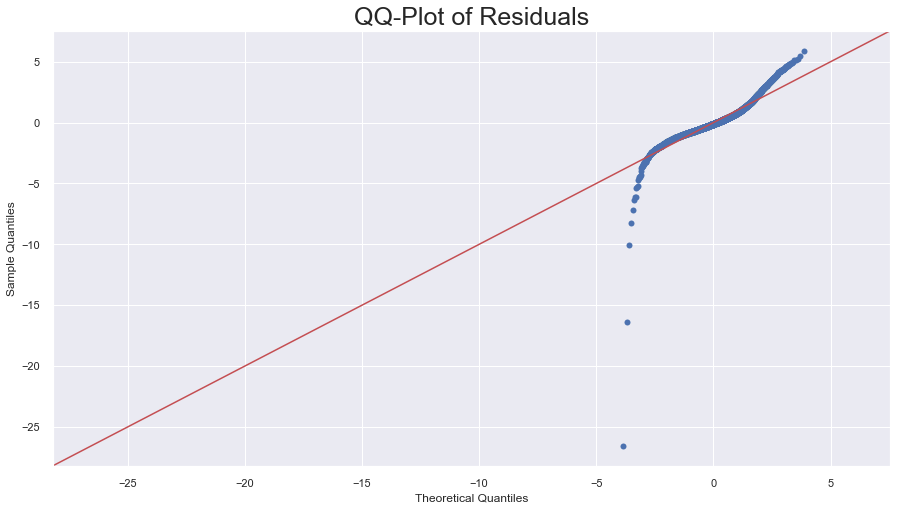

In [93]:
fig, ax = plt.subplots(figsize=(15,8))
residuals = model3.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=ax)
ax.set_title('QQ-Plot of Residuals', fontsize = 25);

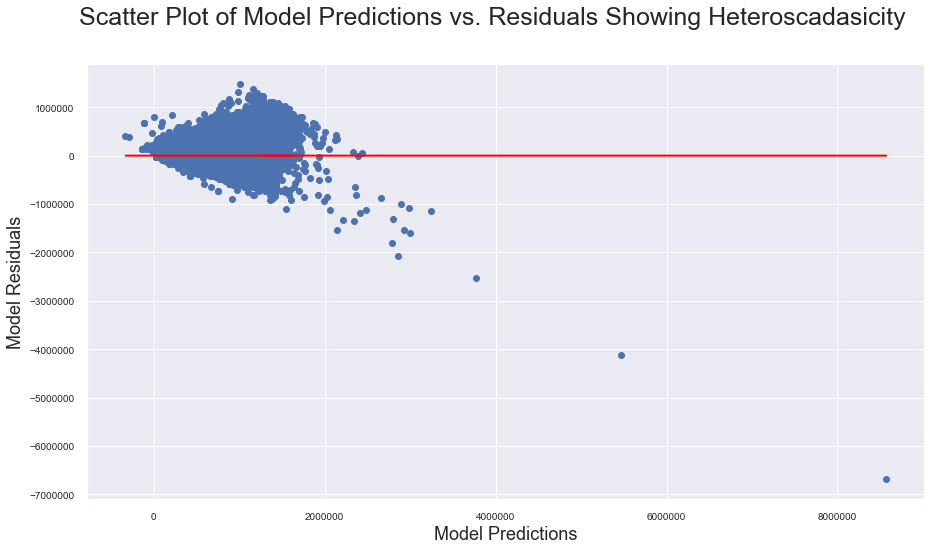

In [94]:
fig, ax = plt.subplots(figsize = (15,8))
plt.scatter(model3.predict(), model3.resid)
sns.set(font_scale = 1)
fig.suptitle('Scatter Plot of Model Predictions vs. Residuals Showing Heteroscadasicity', fontsize = 25)
#ax.set_title('Homoscadasicity Assumption Not Met', fontsize = 20)
plt.xlabel('Model Predictions', fontsize = 18)
plt.ylabel('Model Residuals', fontsize = 18)
ax.tick_params(labelsize=10)
plt.plot(model3.predict(), [0 for i in range(len(df))], color = 'red');

## Model #4 ##
saleprice ~ pricepersqft + baths + squarefoot finished basement

In [96]:
model4_df = df[['saleprice', 'pricepersqft', 'baths', 'sqftfinbasement']].copy()
formula = 'saleprice ~ pricepersqft + baths + sqftfinbasement'
model4 = ols(formula=formula, data=model4_df).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     9287.
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        00:42:41   Log-Likelihood:            -2.4875e+05
No. Observations:               17990   AIC:                         4.975e+05
Df Residuals:                   17986   BIC:                         4.975e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -4.621e+05   7599.905    -60.801      0.000   -4.77e+05   -4.47e+05
pricepersqft     1362.2835     10.965    124.237      0.000    1340.791    1383.776
baths            3.011e+05   2524.041    119.302      0.000    2.96e+05    3.06e+05
sqftfinbasement   136.9959      4.331     31.633      0.000     128.507     145.485
==============================================================================
Omnibus:                     7100.515   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1224408.486
Skew:                          -0.795   Prob(JB):                         0.00
Kurtosis:                      43.385   Cond. No.                     2.51e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Rainbow statistic: 0.9157727096477664
Rainbow p-value: 0.9999848497952103


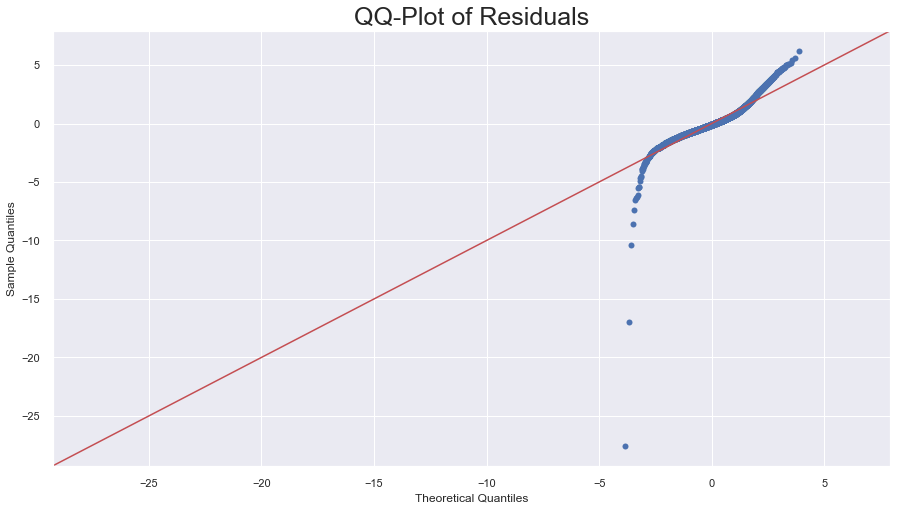

In [101]:
rainbow_statistic, rainbow_p_value = linear_rainbow(model4)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

fig, ax = plt.subplots(figsize=(15,8))
residuals = model4.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=ax)
ax.set_title('QQ-Plot of Residuals', fontsize = 25);


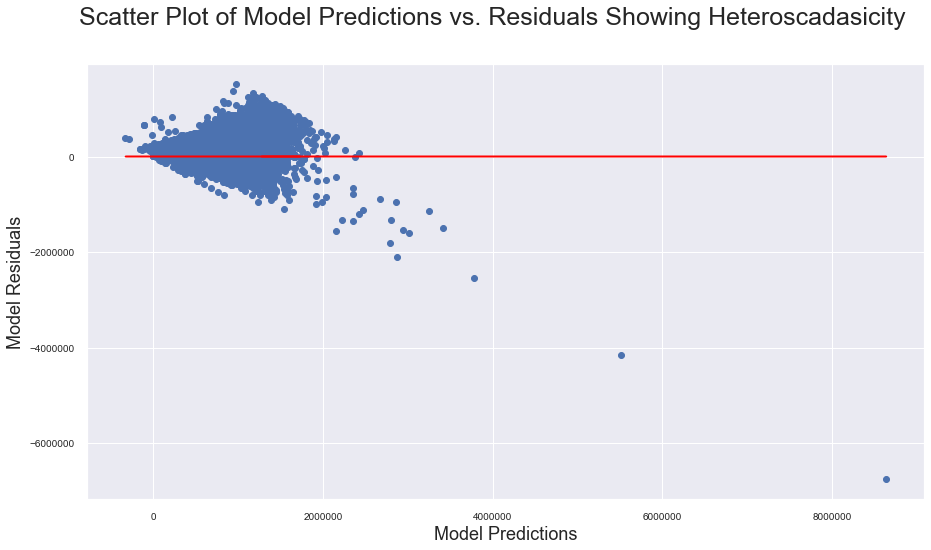

In [99]:
fig, ax = plt.subplots(figsize = (15,8))
plt.scatter(model4.predict(), model4.resid)
sns.set(font_scale = 1)
fig.suptitle('Scatter Plot of Model Predictions vs. Residuals Showing Heteroscadasicity', fontsize = 25)
#ax.set_title('Homoscadasicity Assumption Not Met', fontsize = 20)
plt.xlabel('Model Predictions', fontsize = 18)
plt.ylabel('Model Residuals', fontsize = 18)
ax.tick_params(labelsize=10)
plt.plot(model4.predict(), [0 for i in range(len(df))], color = 'red');

## Model #5 ##
saleprice ~ pricepersqft + baths + squarefoot finished basement + porch

In [100]:
model5_df = df[['saleprice', 'pricepersqft', 'baths', 'sqftfinbasement', 'porch' ]].copy()
formula = 'saleprice ~ pricepersqft + baths + sqftfinbasement + porch'
model5 = ols(formula=formula, data=model5_df).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     7457.
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        00:56:55   Log-Likelihood:            -2.4838e+05
No. Observations:               17990   AIC:                         4.968e+05
Df Residuals:                   17985   BIC:                         4.968e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -4.522e+05   7450.469    -60.692      0.000   -4.67e+05   -4.38e+05
pricepersqft     1359.9238     10.738    126.650      0.000    1338.877    1380.971
baths            2.837e+05   2549.811    111.264      0.000    2.79e+05    2.89e+05
sqftfinbasement   147.1425      4.256     34.569      0.000     138.799     155.485
porch             348.6076     12.542     27.795      0.000     324.024     373.191
==============================================================================
Omnibus:                     8256.773   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1590600.634
Skew:                          -1.092   Prob(JB):                         0.00
Kurtosis:                      49.013   Cond. No.                     2.53e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Rainbow statistic: 0.9339465319279445
Rainbow p-value: 0.9994017670764231


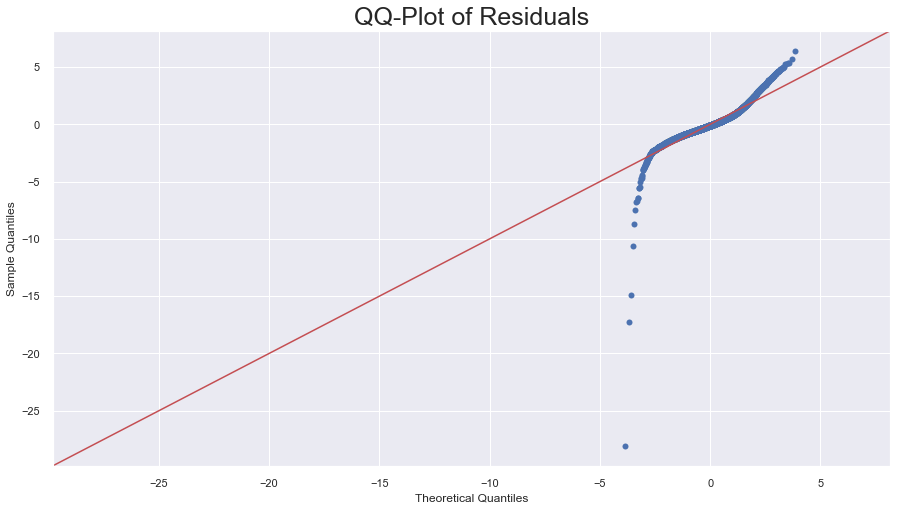

In [102]:
rainbow_statistic, rainbow_p_value = linear_rainbow(model5)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

fig, ax = plt.subplots(figsize=(15,8))
residuals = model5.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=ax)
ax.set_title('QQ-Plot of Residuals', fontsize = 25);

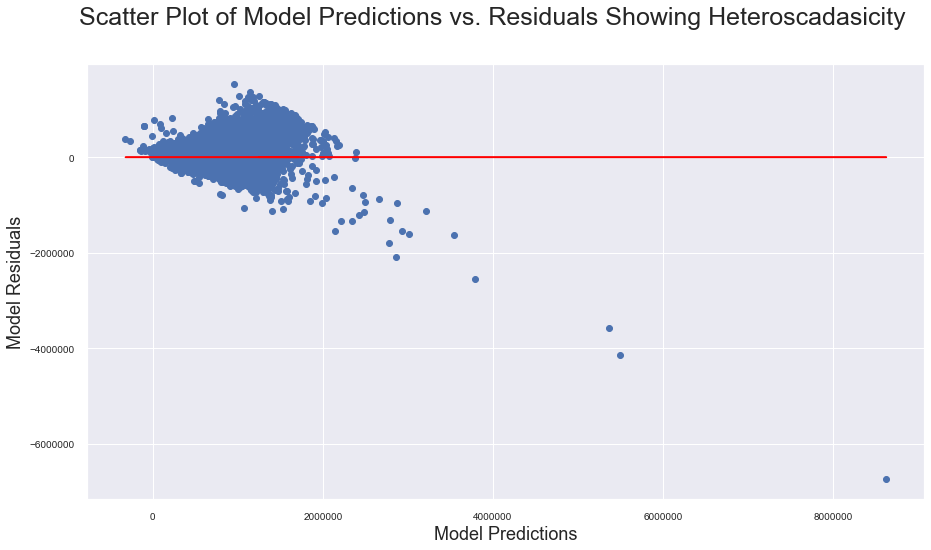

In [103]:
fig, ax = plt.subplots(figsize = (15,8))
plt.scatter(model5.predict(), model5.resid)
sns.set(font_scale = 1)
fig.suptitle('Scatter Plot of Model Predictions vs. Residuals Showing Heteroscadasicity', fontsize = 25)
#ax.set_title('Homoscadasicity Assumption Not Met', fontsize = 20)
plt.xlabel('Model Predictions', fontsize = 18)
plt.ylabel('Model Residuals', fontsize = 18)
ax.tick_params(labelsize=10)
plt.plot(model5.predict(), [0 for i in range(len(df))], color = 'red');

## Model #6 ##
saleprice ~ pricepersqft  + squarefoot finished basement + porch  ---- removed baths to speculate

In [105]:
model6_df = df[['saleprice', 'pricepersqft', 'sqftfinbasement', 'porch' ]].copy()
formula = 'saleprice ~ pricepersqft + sqftfinbasement + porch'
model6 = ols(formula=formula, data=model6_df).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     3445.
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        01:02:54   Log-Likelihood:            -2.5309e+05
No. Observations:               17990   AIC:                         5.062e+05
Df Residuals:                   17986   BIC:                         5.062e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.904e+05   6116.069     31.128      0.000    1.78e+05    2.02e+05
pricepersqft     1133.4281     13.699     82.740      0.000    1106.577    1160.279
sqftfinbasement   273.0136      5.332     51.207      0.000     262.563     283.464
porch             691.6168     15.796     43.783      0.000     660.654     722.579
==============================================================================
Omnibus:                     4779.577   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           422031.800
Skew:                           0.176   Prob(JB):                         0.00
Kurtosis:                      26.725   Cond. No.                     1.54e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model #7 ##
saleprice ~ pricepersqft + baths + squarefoot finished basement + porch + deck

In [107]:
model7_df = df[['saleprice', 'pricepersqft', 'baths', 'sqftfinbasement', 'porch', 'sqftdeck']].copy()
formula = 'saleprice ~ pricepersqft + baths + sqftfinbasement + porch + sqftdeck'
model7 = ols(formula=formula, data=model7_df).fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     6104.
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        01:15:58   Log-Likelihood:            -2.4825e+05
No. Observations:               17990   AIC:                         4.965e+05
Df Residuals:                   17984   BIC:                         4.966e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -4.521e+05   7397.087    -61.116      0.000   -4.67e+05   -4.38e+05
pricepersqft     1348.9874     10.682    126.284      0.000    1328.049    1369.925
baths            2.787e+05   2550.177    109.297      0.000    2.74e+05    2.84e+05
sqftfinbasement   129.5629      4.363     29.692      0.000     121.010     138.116
porch             357.5460     12.465     28.685      0.000     333.114     381.978
sqftdeck          144.6455      8.944     16.172      0.000     127.114     162.177
==============================================================================
Omnibus:                     8249.069   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1573861.412
Skew:                          -1.092   Prob(JB):                         0.00
Kurtosis:                      48.770   Cond. No.                     2.61e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Rainbow statistic: 0.9317800341802491
Rainbow p-value: 0.999595520659029


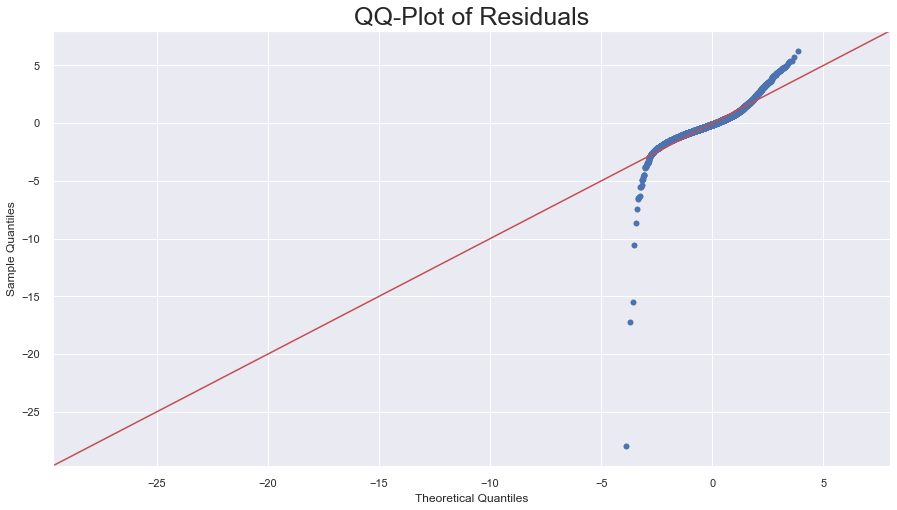

In [108]:
rainbow_statistic, rainbow_p_value = linear_rainbow(model7)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

fig, ax = plt.subplots(figsize=(15,8))
residuals = model7.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=ax)
ax.set_title('QQ-Plot of Residuals', fontsize = 25);

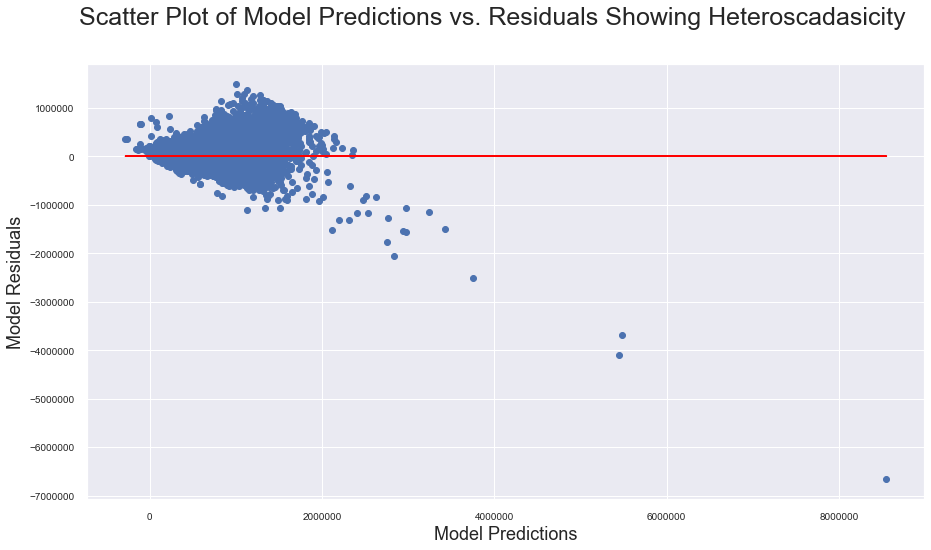

In [109]:
fig, ax = plt.subplots(figsize = (15,8))
plt.scatter(model7.predict(), model7.resid)
sns.set(font_scale = 1)
fig.suptitle('Scatter Plot of Model Predictions vs. Residuals Showing Heteroscadasicity', fontsize = 25)
#ax.set_title('Homoscadasicity Assumption Not Met', fontsize = 20)
plt.xlabel('Model Predictions', fontsize = 18)
plt.ylabel('Model Residuals', fontsize = 18)
ax.tick_params(labelsize=10)
plt.plot(model7.predict(), [0 for i in range(len(df))], color = 'red');